# 微博年龄歧视话题分析

分析微博上关于“老年人”和“熊孩子”的讨论差异。
方法：语料库分析（关键词）、BERT 语义分析。

## Step 1: 导包和读数据

In [18]:
import os
print(os.getcwd())

/Users/tomchung/Documents/Python/25Fall/Corpus


In [19]:
import paddle
paddle.enable_static()
import pandas as pd
import numpy as np
import jieba
import jieba.posseg as pseg
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings

warnings.filterwarnings('ignore')

# 绘图设置
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Heiti TC'] 
plt.rcParams['axes.unicode_minus'] = False

# 1. 读入数据
file_path = 'age.csv' 
try:
    df = pd.read_csv(file_path)
    print("数据读取成功")
except FileNotFoundError:
    print(f"未找到文件 {file_path}，使用模拟数据")
    data = {
        'content': [
            '现在的坏老人真是太多了，倚老卖老，没素质', 
            '熊孩子在车上尖叫，吵死了，家长也不管',
            '老人强行让座，道德绑架',
            '小孩子踢我的椅子，真没教养'
        ] * 25,
        'group': ['Group_Old', 'Group_Child', 'Group_Old', 'Group_Child'] * 25
    }
    df = pd.DataFrame(data)

# 2. 数据概览
display(df.head())
print(df['group'].value_counts())

数据读取成功


,ID,group,content
0,1,Group_Child,这名青少年赢得了舞蹈马拉松比赛。
1,2,Group_Child,一个十六岁的小屁孩能有什么魅力？
2,3,Group_Child,那个17岁的小屁孩什么都不会。
3,4,Group_Child,我的时间全被那些该死的小屁孩浪费了。
4,5,Group_Child,那个小屁孩真没教养，光明正大看人裙底。


group
Group_Child    872
Group_Old      668
Name: count, dtype: int64


## Step 2: 数据预处理

1. **分词**：jieba 分词。
2. **过滤**：去除停用词、种子词、单字。
3. **筛选**：保留名词、动词、形容词。

In [20]:
import jieba
import jieba.posseg as pseg

# 加载停用词
stop_words = set()
try:
    with open('stopwords.txt', 'r', encoding='utf-8') as f:
        for line in f:
            stop_words.add(line.strip())
except FileNotFoundError:
    print("未找到 stopwords.txt")

# 种子词（需剔除）
SEED_WORDS = ['老人', '老头', '老太', '小孩', '孩子','小屁孩','老登','老年人','女儿','儿子','父母'] 

# 1. 添加自定义词典
custom_words = [
    "熊孩子", "坏人变老", "倚老卖老", "老不死的", "老登", 
    "大爷", "大妈", "男宝", "女宝", "好大儿", "巨婴", 
    "没教养", "没素质", "碰瓷", "逼让座"
]
for word in custom_words:
    jieba.add_word(word)

# 2. 分词和词性标注
def corpus_tagging(text):
    if not isinstance(text, str):
        return "", "", ""
    text = text.strip()
    words = pseg.cut(text)
    token_list, pos_list, pair_list = [], [], []
    for word, flag in words:
        token_list.append(word)
        pos_list.append(flag)
        pair_list.append(f"{word}/{flag}")
    return " ".join(token_list), " ".join(pos_list), " ".join(pair_list)

print("分词中...")
df['seg_tokens'], df['pos_tags'], df['word_pos_pairs'] = zip(*df['content'].apply(corpus_tagging))

# 3. 提取 Clean Tokens
def get_clean_tokens(word_pos_pairs_str):
    clean_tokens = []
    if not isinstance(word_pos_pairs_str, str):
        return clean_tokens
    pairs = word_pos_pairs_str.split(' ')
    for pair in pairs:
        if '/' not in pair: continue
        word, flag = pair.rsplit('/', 1)
        if word in stop_words or word in SEED_WORDS or len(word) < 2: continue
        clean_tokens.append(word)
    return clean_tokens

print("清洗中...")
df['clean_tokens'] = df['word_pos_pairs'].apply(get_clean_tokens)

# 4. 保存结果
print("\n--- 预览 ---")
display(df[['content', 'word_pos_pairs', 'clean_tokens']].head(3))
output_filename = "final_corpus_tagged.csv"
df.to_csv(output_filename, index=False, encoding='utf-8-sig')
print(f"已保存: {output_filename}")

# 5. 统计
total_raw_tokens = df['seg_tokens'].apply(lambda x: len(x.split(' ')) if isinstance(x, str) else 0).sum()
total_clean_tokens = df['clean_tokens'].apply(len).sum()
print(f"\n--- 统计 ---")
print(f"原始词数: {total_raw_tokens}")
print(f"清洗后词数: {total_clean_tokens}")
print(f"保留率: {total_clean_tokens/total_raw_tokens:.2%}")

分词中...
清洗中...

--- 预览 ---


,content,word_pos_pairs,clean_tokens
0,这名青少年赢得了舞蹈马拉松比赛。,这/r 名/q 青少年/nr 赢得/v 了/ul 舞蹈/n 马拉松/nr 比赛/vn 。/x,"[青少年, 赢得, 舞蹈, 马拉松, 比赛]"
1,一个十六岁的小屁孩能有什么魅力？,一个十六岁/m 的/uj 小屁孩/nr 能/v 有/v 什么/r 魅力/n ？/x,"[一个十六岁, 魅力]"
2,那个17岁的小屁孩什么都不会。,那个/r 17/m 岁/m 的/uj 小屁孩/nr 什么/r 都/d 不会/v 。/x,[17]


已保存: final_corpus_tagged.csv

--- 统计 ---
原始词数: 18094
清洗后词数: 4684
保留率: 25.89%


## Step 3: 统计与词云

*   **TTR (Type-Token Ratio)**: 词汇丰富度。
*   **词云**: 高频词可视化。

老年组 (Group_Old) TTR (词汇丰富度): 0.6532
儿童组 (Group_Child) TTR (词汇丰富度): 0.5778


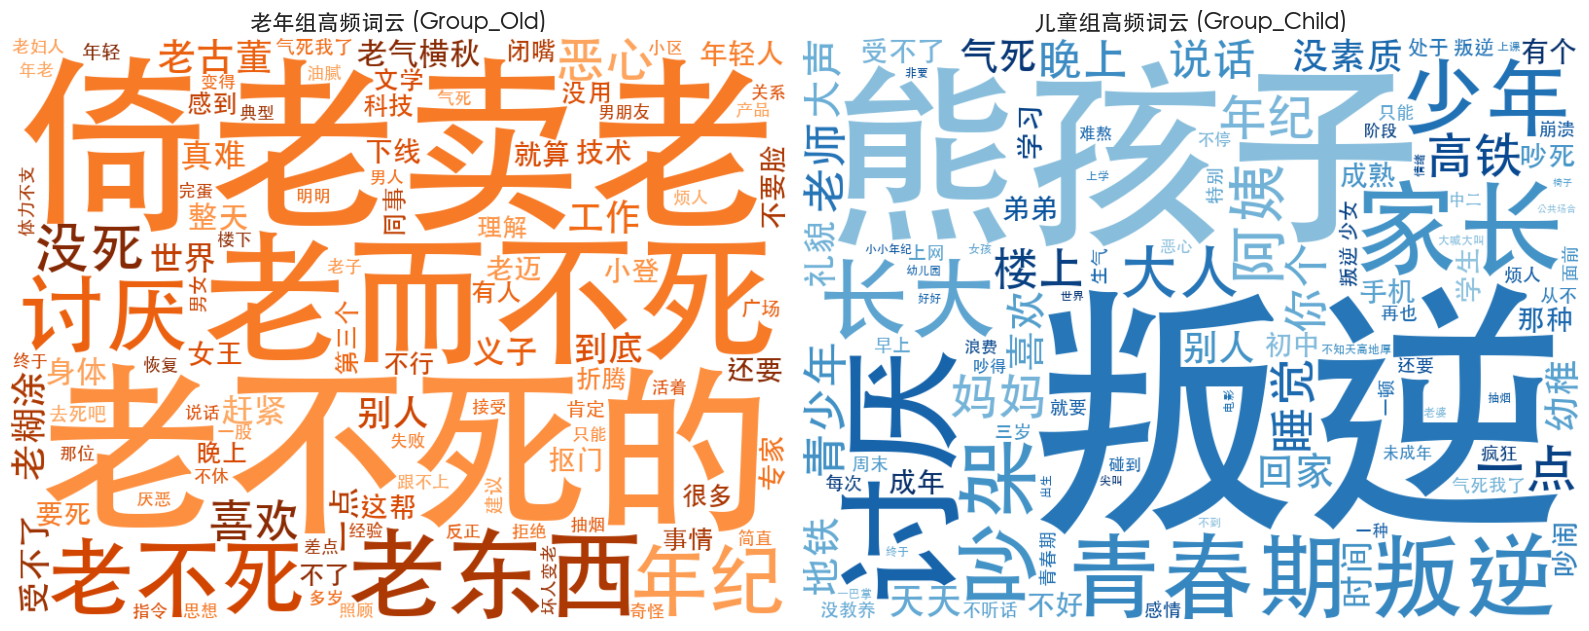

In [ ]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

def calculate_ttr(tokens_list):
    all_tokens = [token for sublist in tokens_list for token in sublist]
    if not all_tokens: return 0
    return len(set(all_tokens)) / len(all_tokens)

tokens_old = df[df['group'] == 'Group_Old']['clean_tokens']
tokens_child = df[df['group'] == 'Group_Child']['clean_tokens']

print(f"老年组 TTR: {calculate_ttr(tokens_old):.4f}")
print(f"儿童组 TTR: {calculate_ttr(tokens_child):.4f}")

def truncate_colormap(cmap_name, minval=0.0, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap_name)
    return mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n)))

def plot_wordcloud(tokens, title, cmap):
    text = ' '.join([t for sublist in tokens for t in sublist])
    wc = WordCloud(
        font_path='/System/Library/Fonts/STHeiti Medium.ttc',
        background_color='white', width=800, height=600, max_words=100, colormap=cmap
    ).generate(text)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_wordcloud(tokens_old, "老年组高频词云", truncate_colormap('Oranges', 0.4, 1.0))
plt.subplot(1, 2, 2)
plot_wordcloud(tokens_child, "儿童组高频词云", truncate_colormap('Blues', 0.4, 1.0))
plt.tight_layout()
plt.show()

## Step 4: 关键词度分析 (Keyness Analysis - RQ1)

**RQ1**: 两类话语的词汇差异？
计算 **Keyness Score** (相对频率差值) 并使用**双向条形图**展示显著词。

--- 关键词分析统计 ---
参与分析的总词汇量 (Unique Words): 22
筛选出的显著差异词 (Plot Data): 20 个 (Top 10 Old + Top 10 Child)


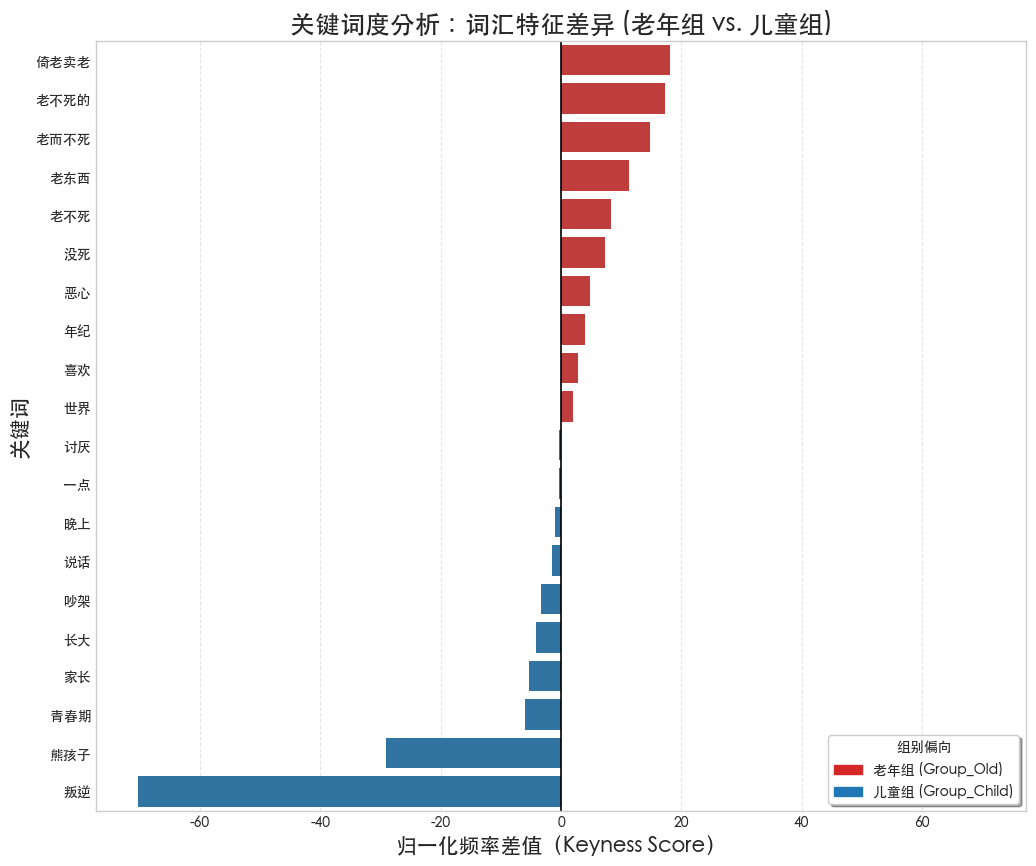

In [ ]:
# 1. 统计词频
def get_word_freq(tokens_series):
    return Counter([w for sublist in tokens_series for w in sublist])

freq_old = get_word_freq(tokens_old)
freq_child = get_word_freq(tokens_child)

df_keyness = pd.DataFrame({
    'freq_old': pd.Series(freq_old),
    'freq_child': pd.Series(freq_child)
}).fillna(0)

# 2. 计算相对频率 (每千词)
df_keyness['norm_old'] = (df_keyness['freq_old'] / sum(freq_old.values())) * 1000
df_keyness['norm_child'] = (df_keyness['freq_child'] / sum(freq_child.values())) * 1000

# 3. 计算 Keyness Score (差值)
df_keyness['diff_score'] = df_keyness['norm_old'] - df_keyness['norm_child']

# 4. 筛选显著词 (总频次 > 10)
df_keyness = df_keyness[(df_keyness['freq_old'] + df_keyness['freq_child']) > 10]
top_old = df_keyness.nlargest(10, 'diff_score')
top_child = df_keyness.nsmallest(10, 'diff_score').sort_values('diff_score', ascending=False)
plot_data = pd.concat([top_old, top_child])

print(f"显著差异词: {len(plot_data)} 个")

# 5. 绘图
plt.figure(figsize=(12, 10))
colors = ['#d62728' if x > 0 else '#1f77b4'  for x in plot_data['diff_score']]
sns.barplot(x=plot_data['diff_score'], y=plot_data.index, palette=colors)

plt.title('关键词度分析 (老年组 vs. 儿童组)', fontsize=18)
plt.xlabel('Keyness Score', fontsize=15)
plt.axvline(0, color='black', linewidth=1.2)
plt.grid(axis='x', linestyle='--', alpha=0.5)

import matplotlib.patches as mpatches
plt.legend(handles=[
    mpatches.Patch(color='#d62728', label='老年组'),
    mpatches.Patch(color='#1f77b4', label='儿童组')
], loc='lower right')
plt.show()

## Step 5: 语义范畴分析 (RQ2)

**RQ2**: 攻击维度的结构性差异？
统计各维度命中率并展示。

各维度占比统计 (%)：


,道德失范,特权滥用,身体污名,感官侵扰,秩序破坏,纯粹厌恶
group,,,,,,
儿童组,3.141361,1.047120,1.047120,5.235602,75.130890,14.397906
老年组,7.582938,19.905213,43.601896,0.947867,4.265403,23.696682


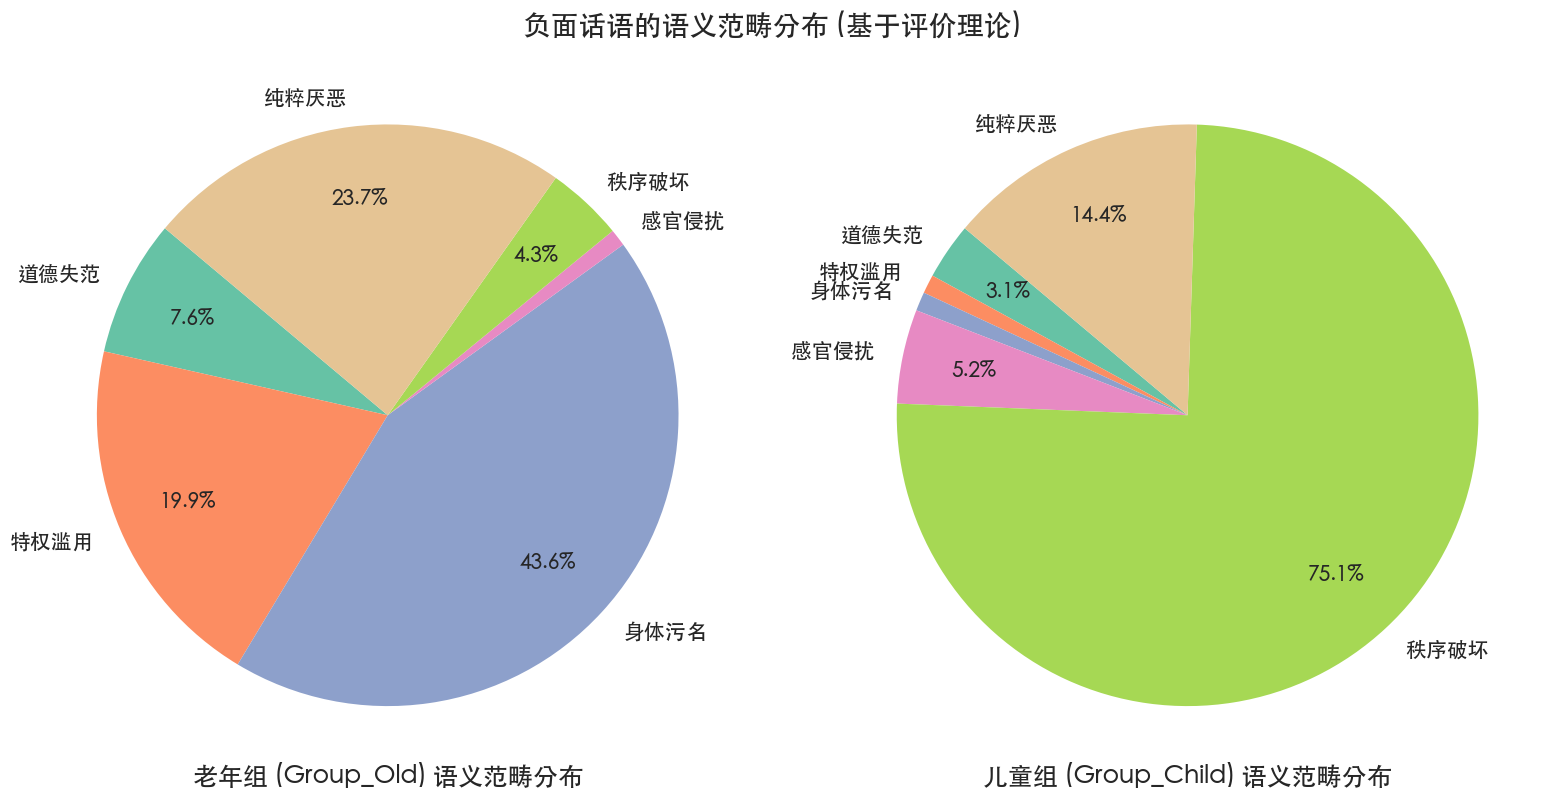

In [ ]:
# 1. 定义语义字典
categories = {
    "道德失范": ["为老不尊", "坏人变老", "坏", "讹", "无赖", "碰瓷", "坏人", "贪婪", "阴险", "好色", "猥琐", "不知羞耻", "没素质", "偷拍", "心眼", "算计", "自私", "虚伪", "缺德", "作孽", "害人", "不讲理", "泼皮", "耍赖", "不要脸", "厚颜无耻", "狡猾"],
    "特权滥用": ["倚老卖老", "逼让座", "道德绑架", "占", "抢", "免费", "优先", "指手画脚", "颐指气使", "强迫", "要求", "霸占", "插队", "命令", "教训", "说教", "干涉", "管闲事", "卖惨", "碰", "占座", "抢占", "理所当然", "特权", "双标"],
    "身体污名": ["老登", "老逼登", "老不死", "老而不死", "棺材", "味道", "老人味", "摔", "倒", "埋", "尸", "暴毙", "苟延残喘", "老东西", "老家伙", "老古董", "老菜帮", "老巫婆", "老头", "老太婆", "皱纹", "皮松", "尿", "失禁", "秃头", "假牙", "脑梗", "腿脚", "入土", "挂", "升天", "死绝", "阴魂不散", "命硬", "难杀", "祸害遗千年"],
    "感官侵扰": ["尖叫", "哭闹", "吵", "闹", "吼", "震", "踢", "跑", "乱动", "蹦", "跳", "炸", "嚎", "撞", "溅", "噪音", "喧哗", "嚷", "喊", "推", "挤", "踩", "喷水", "乱窜", "叽叽喳喳", "鬼哭狼嚎", "哼哼唧唧", "动手动脚", "打扰", "折磨"],
    "秩序破坏": ["熊孩子", "小屁孩", "小登", "没家教", "没教养", "管管", "无法无天", "毁坏", "乱翻", "偷", "搞坏", "欠揍", "撒泼", "叛逆", "闯祸", "神兽", "巨婴", "欠打", "野孩子", "祸害", "捣蛋", "作妖", "手贱", "破坏", "不懂事", "任性", "胡闹", "熊家长", "放养", "不管", "纵容", "溺爱", "无法无天", "有娘生没娘养"],
    "纯粹厌恶": ["恶心", "讨厌", "烦", "滚", "死", "垃圾", "畜生", "贱", "傻逼", "晦气", "痛苦", "崩溃", "绝望", "想吐", "滚蛋", "玩意", "崽子", "孽畜", "毒瘤", "煞笔", "去死", "厌恶", "反胃", "下头", "气死", "无语", "折寿", "神经病", "疯子", "奇葩", "烂人", "该死"]
}

# 2. 统计
def count_categories(tokens, category_dict):
    counts = {k: 0 for k in category_dict.keys()}
    for token in tokens:
        for cat, keywords in category_dict.items():
            if token in keywords: counts[cat] += 1
    return counts

df['cat_counts'] = df['clean_tokens'].apply(lambda x: count_categories(x, categories))

# 3. 汇总
counts_df = pd.DataFrame(df['cat_counts'].tolist())
counts_df['group'] = df['group'].values 
group_stats = counts_df.groupby('group').sum()
group_pct = group_stats.div(group_stats.sum(axis=1), axis=0) * 100
group_pct = group_pct.rename(index={'Group_Old': '老年组', 'Group_Child': '儿童组'})

display(group_pct)

# 4. 绘图
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
palette = sns.color_palette('Set2')
colors = [c for i, c in enumerate(palette) if i != 5] 

def my_autopct(pct): return ('%.1f%%' % pct) if pct > 2 else ''

for i, (group, title) in enumerate(zip(['老年组', '儿童组'], ['老年组', '儿童组'])):
    axes[i].pie(
        group_pct.loc[group], labels=group_pct.columns, autopct=my_autopct, 
        startangle=140, colors=colors, textprops={'fontsize': 15}, pctdistance=0.75
    )
    axes[i].set_title(f'{title} 语义范畴分布', fontsize=18, y=-0.02)

plt.suptitle('负面话语的语义范畴分布', fontsize=20)
plt.tight_layout()
plt.show()

## Step 6: BERT 语义空间投影

使用 **BERT** 提取句向量，通过 **t-SNE** 降维可视化，观察两类话语的语义距离。

BERT 模型加载成功。
正在计算 1540 条样本的 BERT 向量，请稍候...


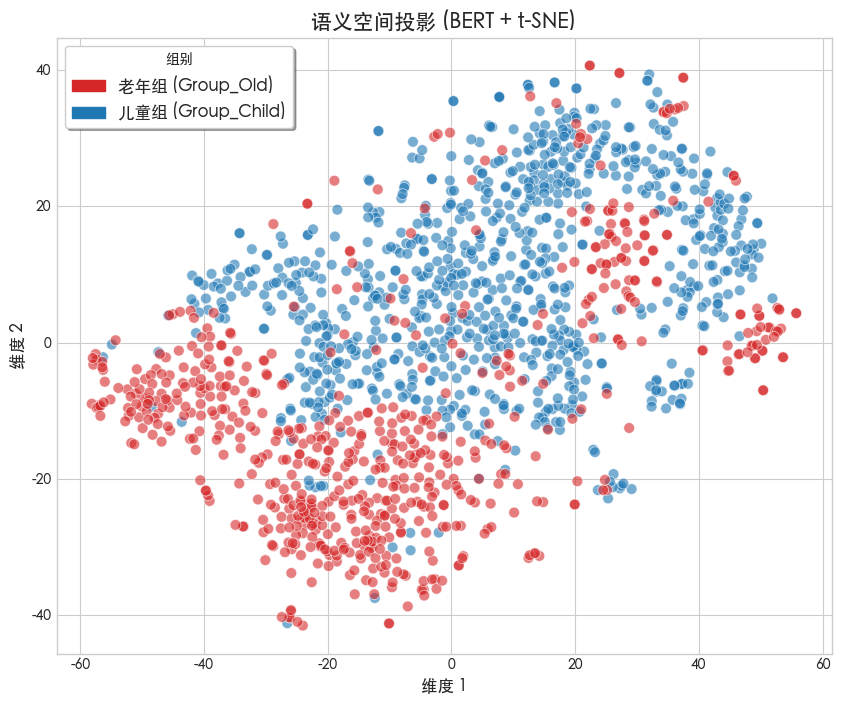

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# 1. 加载 BERT
model_name = 'bert-base-chinese'
try:
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)
    print("BERT 加载成功")
except Exception as e:
    print(f"加载失败: {e}")

# 2. 提取句向量
def get_bert_embedding(text):
    if not isinstance(text, str) or len(text) < 2: return None
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()[0]

# 3. 采样与计算
sample_size = 2000
df_sample = df.sample(sample_size, random_state=42).copy() if len(df) > sample_size else df.copy()
print(f"计算 {len(df_sample)} 条样本向量...")
df_sample['embedding'] = df_sample['content'].apply(get_bert_embedding)
df_sample = df_sample.dropna(subset=['embedding'])

# 4. t-SNE 降维
X = np.stack(df_sample['embedding'].values)
X_embedded = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto').fit_transform(X)
df_sample['x_tsne'] = X_embedded[:, 0]
df_sample['y_tsne'] = X_embedded[:, 1]
df_sample['group_cn'] = df_sample['group'].map({'Group_Old': '老年组', 'Group_Child': '儿童组'})

# 5. 绘图
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_sample, x='x_tsne', y='y_tsne', hue='group_cn', 
                palette={'老年组': '#d62728', '儿童组': '#1f77b4'}, alpha=0.6, s=60, legend=False)
plt.title('语义空间投影 (BERT + t-SNE)', fontsize=15)
plt.legend(handles=[
    mpatches.Patch(color='#d62728', label='老年组'),
    mpatches.Patch(color='#1f77b4', label='儿童组')
], loc='best', title='组别')
plt.show()

## Step 7: 语境索引行提取 (KWIC)

提取关键词上下文 (Key Word in Context) 以支持定性分析。

In [ ]:
def find_concordance(keyword, df_data, num=5, context_window=20):
    print(f"--- 关键词: [{keyword}] ---")
    count = 0
    for text in df_data['content']:
        if not isinstance(text, str) or keyword not in text: continue
        idx = text.find(keyword)
        start, end = max(0, idx - context_window), min(len(text), idx + len(keyword) + context_window)
        print(f"[{count+1}] ...{text[start:end].replace('\n', ' ')}...")
        count += 1
        if count >= num: break
    if count == 0: print("未找到匹配例句。")
    print("\n")

find_concordance('恶心', df[df['group'] == 'Group_Old'])
find_concordance('尖叫', df[df['group'] == 'Group_Child'])
find_concordance('倚老卖老', df[df['group'] == 'Group_Old'])

--- Concordance for keyword: [恶心] ---
[1] ...老登文学真是太恶心了。...
[2] ...一想到那些恶心的老登们，我就反胃。...
[3] ...你这个老不死的，又矮又胖又老，真恶心。...
[4] ...这个老登真是疯了，好恶心。...
[5] ...那些老登真是一个比一个恶心。...


--- Concordance for keyword: [尖叫] ---
[1] ...降噪耳机都压不住小屁孩的尖叫声。...
[2] ...在大街上乱抽烟、到处尖叫的小屁孩就该被捅死。...
[3] ...一群不知天高地厚的小屁孩在疯狂尖叫。...
[4] ...高铁上遇到的小屁孩疯狂吵闹尖叫，一直没停过。...
[5] ...小屁孩能不能别在地铁上尖叫，吵死了！...


--- Concordance for keyword: [倚老卖老] ---
[1] ...喜欢倚老卖老的人，人品都不行。...
[2] ...他倚老卖老，竟然私自圈占小区的公共绿化。...
[3] ...没战绩还倚老卖老，真是不要脸。...
[4] ...他这个人固步自封、倚老卖老，纯属自欺欺人。...
[5] ...自己不擅长还要倚老卖老，说有经验其实根本没有。...


